In [ ]:
from collections import Counter
from csv import reader
import descartes
import fiona
import gensim
from geopandas import GeoDataFrame
import geopy
from IPython.display import Image,display
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import basemap
import mpl_toolkits
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import pyper as pr
import seaborn as sns
import shapely
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import sys

%matplotlib inline


<h1> Topic modeling for community analysis and range estimation </h1>

<p> In this IPython notebook, we're going to run some code and repeat experiments using latent Dirichlet allocation to analyze the communities of plant species that are present in northern Belgium.
<h2> Table of contents</h2>

<ul>
<li>1. Data munging and preprocessing</li>
<li>2. Creating a species presence-absence matrix</li>
<li>3. Visualizing species data</li>
<li>4. Model selection</li>
<li>5. Hyperparameter optimization</li>
<li>6. Analyzing species-community and community-location distributions</li>
<li>7. Making geospatial plots of community prominence</li>
<li>8. Finding indicator species for each community</li>
</ul>

We'll use [Florabank1](http://phytokeys.pensoft.net/articles.php?id=1417), a database of comprising thousands of plant species observed in over 12,000 grid units across the province of Flanders. The wonderful tourist bureau responsible for Flanders has created a wonderful map of the region with some distances drawn out so you can see the scale of the test area.

--2015-12-10 18:25:32--  http://www.visitflanders.com/en/binaries/MapTravelPage_bg_tcm13-9108.png
Resolving www.visitflanders.com (www.visitflanders.com)... 85.255.203.148
Connecting to www.visitflanders.com (www.visitflanders.com)|85.255.203.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114184 (112K) [image/png]
Saving to: ‘MapTravelPage_bg_tcm13-9108.png.2’

MapTravelPage_bg_tc 100%[=====================>] 111.51K   171KB/s   in 0.7s   

2015-12-10 18:25:33 (171 KB/s) - ‘MapTravelPage_bg_tcm13-9108.png.2’ saved [114184/114184]



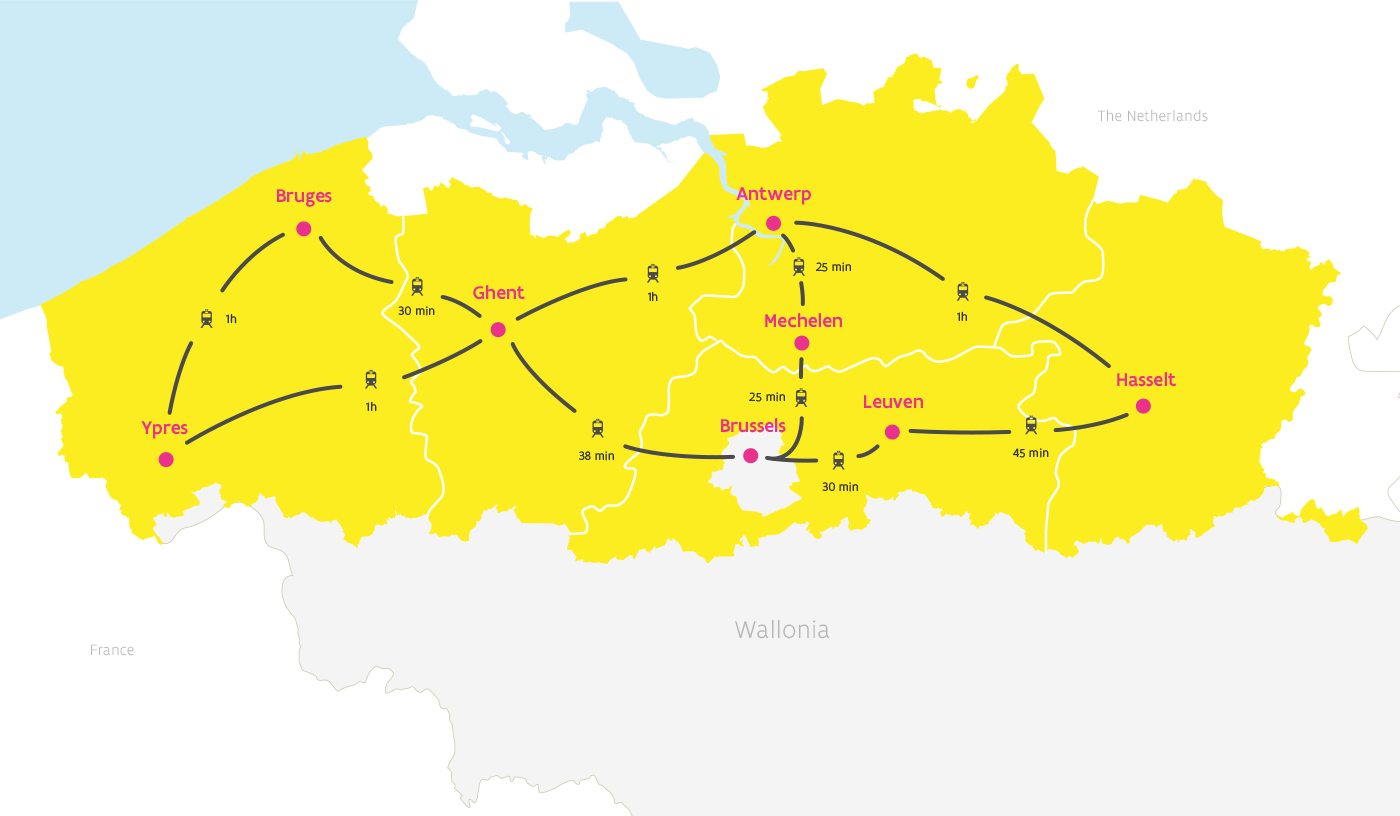

In [5]:
! wget http://www.visitflanders.com/en/binaries/MapTravelPage_bg_tcm13-9108.png
flandersMap = Image('MapTravelPage_bg_tcm13-9108.png')
display(flandersMap)

<h2>Step 1 -  Preprocessing the database and converting it to a term-frequency matrix </h2>

<p>We've got a database of species observations downloaded from GBIF.org and it's in CSV format with a bunch of extraneous information. We eventually need to convert this into a term-frequency matrix which indicates the presence or absence of a recorded observation of a given species at a certain location. We'd like to first clean out some stuff that we don't need. We'll need to perform the following steps: </p>

<ul>
<li>Load the database into a pandas dataframe</li>
<li>Drop any columns which we don't need for this project</li>
<li>Filter out any observations which are not recorded at the 'species' taxonomy level</li>
<li>Filter out any observations which cannot be georeferenced to a grid cell of 1 square kilometer or smaller, i.e. the uncertainty radius is too big</li>
</ul>



In [ ]:
# Before anything else, we need a helper function to wrangle the occurrence CSV data into a list of lists.
def csv2ListOfLists(filename,delimiter='\t'):
    data = [];
    with open(filename,'rb')as dataFile:
        dataReader = csv.reader(dataFile, delimiter=delimiter, quotechar='|')
        counter = 0
        for i,row in enumerate(dataReader):
            temporaryRow = []
            for j,entry in enumerate(row):
                temporaryRow.append(entry) 
            data.append(temporaryRow)
        dataFile.close()
    return data

In [3]:
# WARNING! THIS STEP TAKES A LONG TIME ESPECIALLY IF YOU HAVE A SLOW HD!

# We will print off a lot of info to a log file so we can make sure everything is going smoothly and debug if we need.
logFile = 'log.txt'
logging.basicConfig(filename=logFile,level=logging.INFO)

# The following line takes a CSV filename in the current directory and reads it as a list of lists
# Normally we would want to do a direct import with read_csv and pandas, but there is an error that fires off when we try that.
logging.info("Loading list of lists from CSV file")
occurrenceArray = csv2ListOfLists('occurrence.txt')


In [4]:
# The first list in the list of lists 'occurrenceArray' contains the column name information.
# We'll use that info to name the columns in the pandas dataframe.
logging.info("Converting list of lists to pandas dataframe")
rawOccurrenceDF = pd.DataFrame(occurrenceArray[1:],columns = occurrenceArray[0])


# Let's also keep track of how many records were initially in this database.
rawRecordCount = rawOccurrenceDF.shape[0]

# We need to indicate which columns from this database we'd like to keep and discard the rest.
columnsToKeep = ['id','verbatimCoordinates','decimalLatitude','decimalLongitude','scientificName','taxonRank','coordinateUncertaintyInMeters']

# And we will do an in-place replacement with a reduced pandas dataframe
logging.info("\n Dropping unwanted database fields... \n")
occurrenceDF = rawOccurrenceDF[columnsToKeep]

# Our next step is to eliminate any observation records which do not have a taxonomic rank of "Species".
logging.info("\n Filtering records based on taxon rank... \n")
occurrenceDF = occurrenceDF.query('(taxonRank == "Species")')

# We would also like to eliminate any records in which the uncertainty estimate of location is greater than 1 kilometer.
logging.info("\n Culling records with uncertainty >1000 m. in observation location... \n")
occurrenceDF= occurrenceDF[occurrenceDF.coordinateUncertaintyInMeters.apply(float) <= 1001.0]

processedRecordCount = occurrenceDF.shape[0]

# It would be nice to see some statistics regarding how many records we dropped.
logging.info("\nOut of {:d} records downloaded, {:d} were dropped and {:d} remain in the database.".format(rawRecordCount,processedRecordCount,rawRecordCount-processedRecordCount))

# To control our memory footprint, let's get rid of the big arrays
del occurrenceArray
del rawOccurrenceDF

<h2>Step 2 -  Converting the database to a term-frequency matrix </h2>

<p>Now that the data is cleaned up, we can apply a transformation which will give us a new dataframe in which the row index denotes physical location and the column denotes species presence/absence. Thankfully, pandas has functionality which makes this very easy. </p>


In [7]:
# First, we need to get a list of spatially unique physical locations and also a list of unique species
uniqueLocations = pd.unique(occurrenceDF.verbatimCoordinates.ravel())
uniqueSpecies = pd.unique(occurrenceDF.scientificName.ravel())

# We'll create a new dataframe with the two lists above as the row and column indices
logging.info("\n Creating tf dataframe... \n")
termFrequencyDF = pd.DataFrame(index = uniqueLocations, columns = uniqueSpecies)
termFrequencyDF = termFrequencyDF.fillna(0) # Normally, empty values are initalized to NaN but we want the empties to be set to zero.



# Here, we loop over the occurrence dataframe and populate the term frequency dataframe with the information from the former.
logging.info("\n Filling tf frame with species info \n")
for tup in occurrenceDF[['verbatimCoordinates','scientificName']].itertuples(index=False):
    termFrequencyDF[tup[1]][tup[0]] += 1
    
# The entries in the tf frame are counts, but we really only want presence or absence so we are going to create a new frame with 1s and 0s.
presenceDF = termFrequencyDF.clip(upper=1)


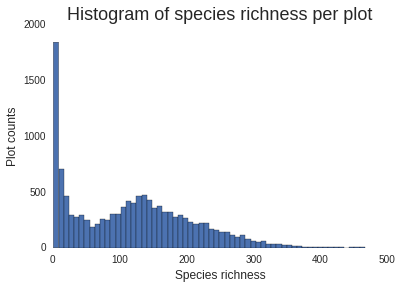

In [392]:
# It would be interesting to see the distribution of species richness over plots.

richnessPerPlot = presenceDF.values.sum(axis=1)
plt.hist(richnessPerPlot,bins=60)
ax = plt.gca()

ax.set_xlabel('Species richness',fontsize = 12)    
ax.set_ylabel('Plot counts',fontsize = 12)
ax.set_axis_bgcolor('white')
_ = plt.title('Histogram of species richness per plot',fontsize = 18)

<h2>Surprise! </h2>
<p> The histogram we just made shows that there are a huge number of sampling plots with very few species in them. What's going on here? Is it sampling bias? Laziness on the part of the survey team? I don't think so. Belgium is a developed country - huge portions of its territory are contiguous agricultural fields with no native/wild plant life.

<h2>Step 3 -  A first visualization of the species data </h2>

<p>Before we perform any analyses, we should know what the most common species are in our test set, as well as the distribution over the number of observed locations per species. </p>

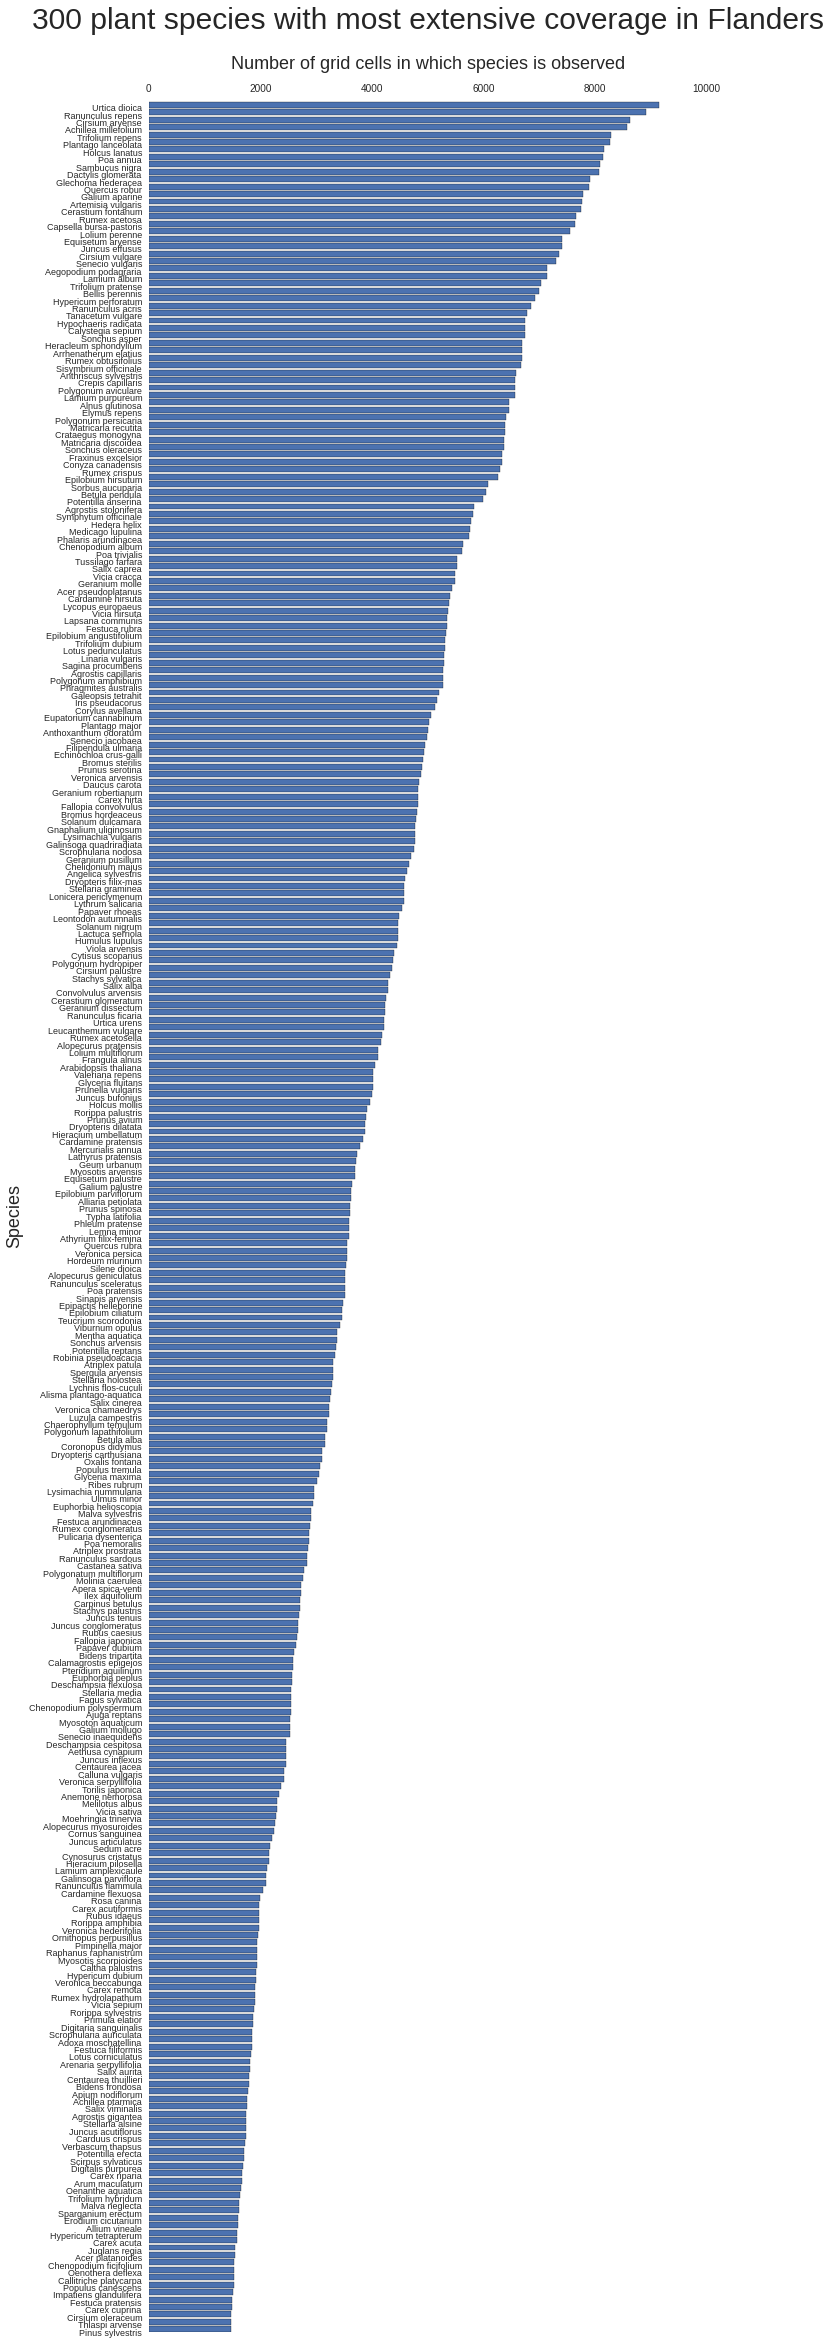

In [369]:
# It would be nice to see the relative frequency of different species. 
# To visualize this, we'll make a bar chart with one bar for each species.

# Here we extract the names of the species and the counts.
speciesNames = presenceDF.columns.values
observedLocationsPerSpecies = presenceDF.values.sum(axis=0)

# We'd like to sort the species by counts, so we need to first zip up the names and the counts such that they are linked.
nameCountTuples = zip(speciesNames,observedLocationsPerSpecies)
sortedTuples = sorted(nameCountTuples, key=lambda species: species[1])

# After it's sorted, we want to recover the original ordered arrays to pass to the plotting function.
# zip() is it's own inverse - we just need to splat the argument, i.e. put the * operator on it.
sortedSpeciesNames,sortedObservedLocationsPerSpecies = zip(*sortedTuples[-300:])

barChartFigure = plt.figure(figsize=(10,40),dpi=800)
yPositions = np.arange(0,len(sortedObservedLocationsPerSpecies))
barHandle = plt.barh(yPositions,
                sortedObservedLocationsPerSpecies)
ticksHandle = plt.yticks(yPositions, sortedSpeciesNames,fontsize=9)

ax = plt.gca()
ax.xaxis.tick_top()
ax.set_xlabel('Number of grid cells in which species is observed',fontsize = 18,labelpad=15)    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Species',fontsize = 18)
ax.set_axis_bgcolor('white')
ax.xaxis.grid(True)

plt.savefig('most_common_species_barchart.png')
_ = plt.title('300 plant species with most extensive coverage in Flanders',y=1.03,fontsize = 30)

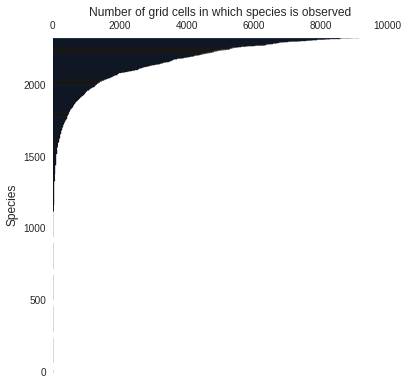

In [370]:
# To see the shape of this count curve over all species, we will need to drop the names.
_,sortedObservedLocationsPerSpecies = zip(*sortedTuples)

barChartFigure = plt.figure(figsize=(6,6),dpi=800)
yPositions = np.arange(0,len(sortedObservedLocationsPerSpecies))
barHandle = plt.barh(yPositions,
                sortedObservedLocationsPerSpecies)

ax = plt.gca()
ax.xaxis.tick_top()
ax.set_xlabel('Number of grid cells in which species is observed',fontsize = 12,labelpad=5)    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Species',fontsize = 12)
ax.set_axis_bgcolor('white')
ax.xaxis.grid(True)
ax.set_ylim([0,len(sortedObservedLocationsPerSpecies)])
plt.savefig('all_species_barchart.png')


<h2>Step 4 - Finding an optimal number of communities via model selection</h2>
<p>Our next step is to use a package written in R by Matthew Taddy at U.Chicago to identify a best setting for the number of communities in our data set, i.e. to find the proper number of topics in latent Dirichlet allocation. I'd recommend giving his arxiv preprint a read: http://arxiv.org/abs/1109.4518 . We are going to use a python package called Pyper to call out to an R process and run the R code before extracting the information that we want regarding the best number of communities and some diagnostic info regarding this optimization process. </p>






In [134]:
# WARNING! This cell also takes a long time to run because of the model selection scheme in R.
# We want to examine a wide range of possible community numbers, i.e. K, but this is computationally expensive.

# First, let's initalize an instance of R which is controlled by the Python kernel via pyper.
r = pr.R()

# Pyper can send data back and forth via frames or matrices but we're going to use a file drop because it will be much faster.
dropFilename = 'presenceMatrixForR.csv'
presenceDF.to_csv(dropFilename,delimiter = ',',header=False,index=False)

# maptpx is the name of the R package we'll use.
r('library(maptpx)')
r('presence<-read.table(\'/home/chris/Dropbox/Public/LDA_project/project_repository/creative/' + dropFilename + '\',sep=\',\')')
r('matrix <- data.matrix(presence)')

# In this scenario, we'll search from possible community numbers from 2 to 40 but this can be adjusted.
logging.info("\n Performing model selection... \n")
outputString = r('summary(simselect <- topics(matrix, K=seq(2,40)), nwrd=0)')

# This extracts the optimal number of communities K per the model selection scheme.
K = r.get('simselect$K')
logging.info("\n The optimal number of communities was identified to be + " + str(K) + ".\n") 

# Let's close out the R instance now that we're done.
del r

print outputString


try({summary(simselect <- topics(matrix, K=seq(2,40)), nwrd=0)})

Estimating on a 12723 document collection.
Fit and Bayes Factor Estimation for K = 2 ... 40
log posterior increase: 3967.5, done.
log BF( 2 ) = 141187.32
log posterior increase: 51299.8, done.
log BF( 3 ) = 253040.54
log posterior increase: 22698.6, done.
log BF( 4 ) = 312046.32
log posterior increase: 19937.4, 1370.3, done.
log BF( 5 ) = 392405.79
log posterior increase: 9711.2, 1022.2, done.
log BF( 6 ) = 427097.44
log posterior increase: 9287.5, 807.9, done.
log BF( 7 ) = 457625.74
log posterior increase: 8611.8, 470.9, done.
log BF( 8 ) = 481101.96
log posterior increase: 7802.5, 1111.1, done.
log BF( 9 ) = 505494
log posterior increase: 6684.3, 302.2, done.
log BF( 10 ) = 526960.74
log posterior increase: 6440.4, 411.8, done.
log BF( 11 ) = 538404.01
log posterior increase: 5867.8, 441.2, 321.8, done.
log BF( 12 ) = 550324.99
log posterior increase: 6000.6, 537.8, 223.9, done.
log BF( 13 ) = 566334.38
log posterior 

<h2>Step 5 - Performing hyperparameter optimization using Gensim</h2>
<p> While many previous works in applied topic modeling were unconcerned about settings of the priors alpha and eta, Hanna Wallach made a strong case for investigating how they are chosen in a 2009 paper. Check it out here if you're interested: https://people.cs.umass.edu/~wallach/publications/wallach09rethinking.pdf. We're going to use Gensim, a topic modeling package which can learn the best LDA hyperparameter / prior settings directly from the data per the recommendations from that paper.  </p>



In [135]:
# Gensim has its own corpus format that we need to convert to from a numpy matrix / pandas dataframe
presenceGS = gensim.matutils.Dense2Corpus(np.copy(presenceDF.values), documents_columns=False)
model = gensim.models.ldamodel.LdaModel(corpus=presenceGS, num_topics=K, distributed=False, alpha='auto', eta='auto', iterations = 20, passes = 2, minimum_probability = 0.001)

# Let's also extract the parameter matrices that were estimated.
# This pulls out the set of location-community distributions, commonly referred to in the literature as theta.
theta =  gensim.matutils.corpus2dense(model[presenceGS],model.num_topics)

# And here's the unnormalized community-species distributions.
phi = model.expElogbeta

# As the final step, we extract the inferred hyperparameters so we can use them in other LDA runs.
alpha = model.alpha
eta = model.eta

<h2>Step 6 - Analyzing communities-species and location-community relationships</h2>
<p>In the previous code block we ran an inference routine (variational expectation maximization as an implementation of the methods outlined by Hoffman et al. 2010 at http://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf) to identify optimal settings of the hyperparameters alpha and eta. We also identified lots of interesting structure so let's take a look at the spatial distributions of the communities we identified as well as the indicator species which each community contains. </p>

In [188]:
# The first thing we are going to do is rewrite the parameters that we got into pandas dataframes so we can see which species are most important for each community.
speciesCommunityDF = pd.DataFrame(data = phi, index = [str(i) for i in range(1,K+1)],columns = presenceDF.columns.values)

# We will do the same for the community-location parameters.
communityLocationDF = pd.DataFrame(data = theta.transpose(), index = presenceDF.index.values, columns = ['community'+str(i) for i in range(1,K+1)])

# To make spatial plots of community prominence, we need to join tables.
# The next line is tricky - we're going to merge with occurrenceDF but we don't need all 3 million records. We only want the unique plot ID values and the corresponding spatial coordinates.
communityLocationDF = pd.merge(communityLocationDF,occurrenceDF.drop_duplicates(subset=['verbatimCoordinates']),right_on='verbatimCoordinates',how='left',left_index=True)

# We should also get rid of unnecessary columns which got merged from the occurrence dataframe.
communityLocationDF = communityLocationDF.drop(['id','coordinateUncertaintyInMeters','scientificName','taxonRank'],axis=1)
communityLocationDF = communityLocationDF.set_index('verbatimCoordinates')

# While we're at it, let's make a new directory for our dataframes and save them in case we want to come back later and skip all the busywork.
! mkdir dataframes
dfFilenames = ['speciesCommunityDF','communityLocationDF','termFrequencyDF','occurrenceDF']
for i,frame in enumerate([speciesCommunityDF,communityLocationDF,termFrequencyDF,occurrenceDF]):
    frame.to_csv('dataframes/'+dfFilenames[i]+'.csv')

<h2>A brief interlude</h2>
<p> It's time to save our significant work so far, namely the pandas dataframes which we've been making up until now. </p>

In [313]:
# While we're at it, let's make a new directory for our dataframes and save them in case we want to come back later and skip all the busywork.
! mkdir dataframes
dfFilenames = ['speciesCommunityDF','communityLocationDF','termFrequencyDF','occurrenceDF']
for i,frame in enumerate([speciesCommunityDF,communityLocationDF,termFrequencyDF,occurrenceDF]):
    frame.to_csv('dataframes/'+dfFilenames[i]+'.csv')

mkdir: cannot create directory ‘dataframes’: File exists


<h2>Step 7 - Projecting geospatial data and plotting it with matplotlib </h2>

<p>Things are about to get crazy. The projection and plotting will follow along the lines of the workflows described here: https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/ and also from the mpl homepage http://matplotlib.org/basemap/users/examples.html. </p>

In [485]:
# In the examples below, we're going to need to plot some spatial data on a base map.
# Here, we'll define a function specifically for this example to return a basemap to plot on.
def flandersBasemap(llLong,llLat,urLong,urLat):
    
    fig = plt.figure(figsize=(10,5))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])

    # We are going to use the Basemap class from the matplotlib toolkits library.
    # The extent of our map is going to be over the latitudes/longitudes in which there is data.

    

    # The projection we want to use is the Mercator projection.
    # Rendering all of this is highly dependent on the resolution.
    # The resolution can be changed to 'l' if this generates too slowly.
    bmap = basemap.Basemap(projection='merc',
                      llcrnrlon=llLong,
                      llcrnrlat=llLat,
                      urcrnrlon=urLong,
                      urcrnrlat=urLat,
                      resolution='f')

    bmap.drawcoastlines(linewidth=0.25)
    bmap.drawcountries(linewidth=0.5)
    bmap.drawmapboundary(fill_color='aqua')
    bmap.drawparallels(np.arange(lowerLeftCornerLatitude,upperRightCornerLatitude,.2),labels=[1,0,0,0], linewidth=0.0)
    bmap.drawmeridians(np.arange(lowerLeftCornerLongitude,upperRightCornerLongitude,.5),labels=[0,0,0,1], linewidth=0.0)

    bmap.fillcontinents(color='lightblue',lake_color='aqua',zorder=0)
    return bmap

In [ ]:
lowerLeftCornerLongitude  = min([float(i) for i in communityLocationDF['decimalLongitude'].values])-.1
lowerLeftCornerLatitude   = min([float(i) for i in communityLocationDF['decimalLatitude'].values])-.1
upperRightCornerLongitude = max([float(i) for i in communityLocationDF['decimalLongitude'].values])+.1
upperRightCornerLatitude  = max([float(i) for i in communityLocationDF['decimalLatitude'].values])+.1

bmap = flandersBasemap(lowerLeftCornerLongitude,lowerLeftCornerLatitude,upperRightCornerLongitude,upperRightCornerLatitude)

# To visualize the prominence of communities across space, we're going to make our own sort-of colormap.
# It won't be a real colormap; we're just messing with the alpha values. Higher prominence means higher alpha.
rgbaColors = np.zeros((len(alphas),4))
rgbaColors[:,1] = 0.5

# These are the latitude-longitude coordinates.
x = [float(i) for i in communityLocationDF['decimalLongitude'].values]
y = [float(i) for i in communityLocationDF['decimalLatitude'].values]

# This array will hold a list of ipython image objects so we can show the plots in Ipython quickly later.
ipythonImages = []

# We'll also create a directory to put the saved image files in.
! mkdir basemap_community_plots

for i in range(1,K+1):
    alphas = communityLocationDF['community'+str(i)].values
    
    rgbaColors[:,3] = alphas/alphas.max()
    
    sc = bmap.scatter(x,y,latlon=True,s=4,c=rgbaColors,edgecolor='')
    plt.title('Community '+str(i),fontsize=36)
    plt.savefig('basemap_community_plots/community'+str(i)+'.png',dpi=800)
    ipythonImages.append(Image(filename='basemap_community_plots/community'+str(i)+'.png'))
    sc.remove()

# Remember how earlier we wanted to make a spatial plot of species richness? Now we can go ahead and do that.
alphas = presenceDF.values.sum(axis=1)
rgbaColors = np.zeros((len(alphas),4))
rgbaColors[:,0] = 0.5
rgbaColors[:,3] = alphas.astype('float')/alphas.max().astype('float')

plt.title('Species richness',fontsize=24)
sc = bmap.scatter(x,y,latlon=True,s=4,c=rgbaColors,edgecolor='')
plt.savefig('richness.png',dpi=800)  
richnessImage = Image(filename='richness.png')
    
# Now let's see what they look like!
for image in ipythonImages:
    display(image)
display(richnessImage)

<h2>Step 8 - Identifying indicator species </h2>
<p>A major component of community analysis is determining the characteristic species for each community, a.k.a. the indicator species. These are often very helpful for understanding what the community represents.
</p>

In [412]:
for communityName,community in speciesCommunityDF.iterrows():
    
    # The indicator species are going to be the ones with the highest probability in each community distribution.
    print(communityName + '\n')
    print(community.nlargest(10))
    print('\n\n')

1

Hieracium umbellatum    0.017796
Achillea millefolium    0.016547
Plantago lanceolata     0.015511
Ranunculus acris        0.015473
Hypochaeris radicata    0.015131
Urtica dioica           0.012284
Lysimachia vulgaris     0.012149
Quercus robur           0.011464
Teucrium scorodonia     0.010822
Ranunculus repens       0.010557
Name: 1, dtype: float64



2

Solidago virgaurea       0.014002
Rorippa austriaca        0.010149
Lupinus polyphyllus      0.009406
Misopates orontium       0.008309
Stachys arvensis         0.007131
Ranunculus bulbosus      0.004677
Chrysanthemum segetum    0.004497
Vicia cracca             0.004022
Campanula rapunculus     0.004007
Crepis capillaris        0.003500
Name: 2, dtype: float64



3

Hordeum murinum        0.009526
Acer pseudoplatanus    0.007921
Senecio jacobaea       0.007808
Chelidonium majus      0.007449
Sambucus nigra         0.007044
Hedera helix           0.007029
Conyza canadensis      0.006940
Geranium pusillum      0.006816
Polygonum a

<p> Community 11, for example, is almost entirely plants that do well around water. This can be seen just from the name of some of the indicator species:</p>


`
Callitriche platycarpa      0.009989

Oenanthe aquatica           0.009704

Alisma plantago-aquatica    0.009667

Rorippa palustris           0.009139

Typha latifolia             0.008655

Echinochloa crus-galli      0.008485

Gnaphalium uliginosum       0.008413

Lycopus europaeus           0.008252

Lotus pedunculatus          0.007694

Polygonum amphibium         0.007469
`

<p>A cursory wikipedia search reveals that these are indeed plants that thrive in freshwater environments. Among these species are varieties of waterworts, cattails, marsh grasses and aquatic knotweeds.</p>





<h2>To be continued...</h2>
<p>These experiments have to be split into multiple notebooks to keep the memory footprint reasonable. In the next one we'll do range estimation and some other cool stuff!</p>